In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import pandas as pd
import astropy

In [2]:
z = 3.76

In [3]:
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

In [4]:
cosmo = FlatLambdaCDM(H0=67, Om0=0.3)
d_l = cosmo.luminosity_distance(z).value*3.086e24
A = (1+z)/(4*np.pi*(d_l**2))
A

3.2840016590416415e-59

In [5]:
my_phot = np.asarray(pd.read_csv('Phot_Ext_Sers_5.csv', header = None))
my_phot

array([[5.60000000e+00, 4.34978342e+01, 7.15104394e+00],
       [7.70000000e+00, 8.56339155e+01, 1.40782157e+01],
       [1.00000000e+01, 1.01170694e+02, 1.66324621e+01],
       [1.28000000e+01, 6.18713767e+01, 1.01716543e+01],
       [1.50000000e+01, 6.59951096e+01, 1.08495960e+01],
       [1.80000000e+01, 5.94062260e+01, 9.76638355e+00],
       [2.78600000e+00, 5.89305348e+00, 9.68817992e-01],
       [3.56300000e+00, 1.77931614e+01, 2.92519573e+00],
       [4.42100000e+00, 1.95448840e+01, 3.21317893e+00],
       [2.50000000e+02, 7.30000000e+04, 1.20000000e+04],
       [3.50000000e+02, 1.14000000e+05, 1.40000000e+04],
       [5.00000000e+02, 1.16000000e+05, 1.50000000e+04]])

In [6]:
my_phot = np.reshape(my_phot,(36))

In [7]:
my_phot_array_lam = np.array(my_phot[::3])
my_phot_array_flux = np.array(my_phot[1::3])*1e-29
my_phot_array_err = np.array(my_phot[2::3])*1e-29

In [8]:
my_phot_array_flux

array([4.34978342e-28, 8.56339154e-28, 1.01170694e-27, 6.18713767e-28,
       6.59951096e-28, 5.94062260e-28, 5.89305348e-29, 1.77931614e-28,
       1.95448840e-28, 7.30000000e-25, 1.14000000e-24, 1.16000000e-24])

In [9]:
my_phot_rand = np.random.normal(loc = my_phot_array_flux, scale = my_phot_array_err, size = (300,12))

In [10]:
templates = ('Blue_SF_glx.norm_LIR','BroadFIR_SF_glx.norm_LIR','Cold_glx.norm_LIR','Elliptical.norm_LIR','Ly_break.norm_LIR','MIR_powlaw_SF_glx.norm_LIR','MIRex_SF_glx.norm_LIR','Mod_SF_glx.norm_LIR','Obs_SF_glx.norm_LIR','PAH_SF_glx.norm_LIR','Red_SF_glx_1.norm_LIR','Red_SF_glx_2.norm_LIR','Secular_glx.norm_LIR','SF_glx_1.norm_LIR','SF_glx_2.norm_LIR','SF_Type1_AGN_1.norm_LIR','SF_Type1_AGN_2.norm_LIR','SF_Type1_AGN_3.norm_LIR','SF_Type1_AGN_4.norm_LIR','SF_Type2_AGN_1.norm_LIR','SF_Type2_AGN_2.norm_LIR','SF_Type2_AGN_3.norm_LIR','Si_break.norm_LIR','Spiral.norm_LIR','Torus.norm_LIR','Type1_AGN_1.norm_LIR','Type2_AGN_1.norm_LIR','Type2_AGN_2.norm_LIR','Warm_SF_glx.norm_LIR','WeakPAH_SF_glx_1.norm_LIR','WeakPAH_SF_glx_2.norm_LIR','Young_SF_glx.norm_LIR')

In [11]:
wavelength_indexes = np.array([ 6374,  6396,  6421,  6450,  6473,  6505,  2878,  4510,  6313,
       10796, 10811, 10826])

In [12]:
def k_calc(temps,fluxes_input):
    sed = ascii.read(temps)
    lam_tab = sed['col1']  * 10.0**(-4.0)   # microns
    Llam_tab = sed['col2']  # erg/s/Angstrom
    nu_tab = 3.0*10.0**8.0/(lam_tab*10.0**(-6.0))   # Hz
    Lnu_tab = Llam_tab/nu_tab**2.0   
    lam_tab_z = lam_tab*(z+1)
    
    sed_phot_lum  = np.array(Lnu_tab[wavelength_indexes])
    
    k_num = np.sum((fluxes_input*sed_phot_lum)/(my_phot_array_err**2))
    k_denom = np.sum((sed_phot_lum**2)/(my_phot_array_err**2))
    k = k_num/k_denom
    
    chi2 = np.sum(((fluxes_input - k*sed_phot_lum)/my_phot_array_err)**2)
    return k, chi2, Lnu_tab, lam_tab_z, nu_tab, lam_tab

In [13]:
k_list = np.zeros([len(my_phot_rand),len(templates)])
chi2_list = np.zeros([len(my_phot_rand),len(templates)])
lam_tab_list = np.zeros([len(my_phot_rand),len(templates),11005]) #3d
lam_tab_z_list = np.zeros([len(my_phot_rand),len(templates),11005]) #3d
Lnu_tab_list = np.zeros([len(my_phot_rand),len(templates),11005]) #3d
nu_tab_list = np.zeros([len(my_phot_rand),len(templates),11005]) #3d
best_templates = []
best_k = np.zeros([len(my_phot_rand)])
best_LIR = []
best_H = []

for i in range(len(my_phot_rand)):
    print('realisation',i+1)
    for j in range(len(templates)):
        k_list[i][j],chi2_list[i][j],Lnu_tab_list[i][j],lam_tab_z_list[i][j],nu_tab_list[i][j],lam_tab_list[i][j]= k_calc(templates[j],my_phot_rand[i])
    bestchi2 = np.min(chi2_list[i])
    loc = np.where(chi2_list[i] == bestchi2)
    loc = loc[0][0]
    best_templates.append(templates[loc])
    best_k = k_list[i][loc]
    scaling_constant = best_k/A
    temp_freq_LIR = []
    temp_lum_LIR = []
    temp_freq_H = []
    temp_lum_H = []
    for m in range(len(lam_tab_list[i][loc])):
        if (lam_tab_list[i][loc][m] > 3) and (lam_tab_list[i][loc][m] < 1100):
            temp_lum_LIR.append(Lnu_tab_list[i][loc][m])
            temp_freq_LIR.append(nu_tab_list[i][loc][m])
        if (lam_tab_list[i][loc][m] > 1.3) and (lam_tab_list[i][loc][m] < 1.9):
            temp_lum_H.append(Lnu_tab_list[i][loc][m])
            temp_freq_H.append(nu_tab_list[i][loc][m])
    temp_lum_LIR = np.array(temp_lum_LIR)
    temp_freq_LIR = np.array(temp_freq_LIR)
    temp_lum_H = np.array(temp_lum_H)
    temp_freq_H = np.array(temp_freq_H)
    LIR = np.trapz(temp_lum_LIR*scaling_constant,temp_freq_LIR)
    H_band = np.trapz(temp_lum_H*scaling_constant,temp_freq_H)
    best_LIR.append(LIR)
    best_H.append(H_band)
    

realisation 1
realisation 2
realisation 3
realisation 4
realisation 5
realisation 6
realisation 7
realisation 8
realisation 9
realisation 10
realisation 11
realisation 12
realisation 13
realisation 14
realisation 15
realisation 16
realisation 17
realisation 18
realisation 19
realisation 20
realisation 21
realisation 22
realisation 23
realisation 24
realisation 25
realisation 26
realisation 27
realisation 28
realisation 29
realisation 30
realisation 31
realisation 32
realisation 33
realisation 34
realisation 35
realisation 36
realisation 37
realisation 38
realisation 39
realisation 40
realisation 41
realisation 42
realisation 43
realisation 44
realisation 45
realisation 46
realisation 47
realisation 48
realisation 49
realisation 50
realisation 51
realisation 52
realisation 53
realisation 54
realisation 55
realisation 56
realisation 57
realisation 58
realisation 59
realisation 60
realisation 61
realisation 62
realisation 63
realisation 64
realisation 65
realisation 66
realisation 67
real

In [254]:
#np.log10(np.abs(best_LIR))

In [14]:
#np.array(best_LIR)/3.826e33
best_chi2_list = []
for i in range(len(chi2_list)):
    chi2_list = np.array(chi2_list)
    lowest_chi2 = np.min(chi2_list[i])
    best_chi2_list.append(lowest_chi2)

In [15]:
best_chi2_list

[121.11383401265809,
 81.65427064161088,
 80.93573742363134,
 91.11780783436537,
 107.7005507101842,
 68.09206510272135,
 88.77868459648369,
 72.03058619617178,
 95.06525172269176,
 111.40239274953996,
 137.5759244733355,
 85.2923657557211,
 119.41543254870626,
 101.67574909377706,
 80.04954718855244,
 125.076415391502,
 120.2755962105384,
 104.93867357508651,
 86.1010773613848,
 96.7896220035303,
 95.9456726203638,
 88.47336732704673,
 117.30789235639149,
 140.8468059128096,
 102.52010312529958,
 128.23259020802976,
 71.88722885339195,
 118.51321362574541,
 101.11270970255109,
 90.6528139308023,
 85.67027374360856,
 144.76716352586172,
 67.01530929020512,
 90.97924119801313,
 104.005795747822,
 75.31582433684756,
 87.68155016163989,
 94.54497179245065,
 132.31876483980508,
 101.31582790973299,
 114.18532041118789,
 93.02311686357015,
 86.76822579391269,
 81.65594566040285,
 78.44672865862779,
 118.77717675694032,
 96.10993142260925,
 124.93214735674844,
 107.74229375210966,
 108.38236

In [16]:
log_LIR = np.random.normal(np.log10(np.abs(best_LIR)),0.1,len(best_LIR))
log_LIR

array([47.04880992, 46.95550002, 47.137938  , 46.93272409, 47.21637249,
       47.10224401, 47.04275111, 47.04687176, 46.79702625, 47.00107856,
       47.05490808, 47.23843448, 46.8515892 , 46.96892701, 47.15902641,
       46.74128739, 47.05261842, 46.88297549, 47.10396374, 47.22438622,
       46.88695097, 47.06855526, 46.98036414, 46.82240785, 46.92974768,
       46.80169419, 46.88360564, 47.15358975, 46.82481016, 47.02440755,
       47.0617196 , 46.82856681, 46.79732369, 46.8993772 , 47.0170512 ,
       46.93498922, 46.88245761, 47.02336229, 46.62392319, 46.93379088,
       46.91212136, 46.95544568, 46.9025672 , 46.90158353, 47.17787576,
       46.90137551, 46.86748254, 47.1229292 , 47.01483761, 47.15068381,
       47.1067148 , 46.83151607, 47.07185708, 47.25056781, 47.05281893,
       46.83687591, 47.29913693, 46.82296927, 46.84594992, 46.96741301,
       46.8472433 , 46.92727925, 47.11533618, 46.96234896, 47.21729495,
       46.87565002, 47.05976826, 47.07700935, 47.29319102, 46.93

In [17]:
SFR = 10**(log_LIR-43.41)
SFR

array([4353.21300102, 3511.55942615, 5344.88055103, 3332.14649277,
       6402.83770277, 4923.16063095, 4292.90336523, 4333.82883953,
       2437.95814446, 3900.12525986, 4414.77001328, 6736.50254703,
       2764.32559927, 3621.82125666, 5610.82095369, 2144.30910402,
       4391.55591295, 2971.49835709, 4942.69416659, 6522.08150446,
       2998.82395462, 4555.70147231, 3718.46881856, 2584.68633815,
       3309.38794356, 2464.30347466, 2975.81301759, 5541.02044011,
       2599.02319505, 4115.35733371, 4484.55755449, 2621.60231949,
       2439.62844203, 3085.86696843, 4046.23587413, 3349.57121511,
       2967.95706224, 4105.46438033, 1636.52706609, 3340.34160422,
       3177.76196333, 3511.1200572 , 3108.61686795, 3101.5838775 ,
       5859.70507901, 3100.0985934 , 2867.36208265, 5163.32187158,
       4025.66479526, 5504.06825972, 4974.10327166, 2639.46598447,
       4590.46920117, 6927.36081536, 4393.58400997, 2672.24273504,
       7747.06027037, 2588.02976055, 2728.66313462, 3609.21709

In [18]:
mag_factor = 6.9 #Taken from High resolution spectral imaging of CO(7–6), [CI](2–1), and continuum of three high-z lensed dusty star-forming galaxies using ALMA
mag_factor_dispersion = 0.1
mag_list = np.random.normal(mag_factor,mag_factor_dispersion,len(best_LIR))


In [19]:
mag_corrected_SFR = SFR/mag_list
log_mag_corrected_SFR = np.log10(mag_corrected_SFR) #plot this one

In [20]:
H_band_solar_lum = np.array(best_H)/3.826e33

In [21]:
log_H = np.random.normal(np.log10(np.abs(H_band_solar_lum)),0.1,len(best_H))
log_H

array([11.70925832, 11.74140289, 11.20449087, 11.60248752, 11.14366659,
       11.21920761, 11.59927814, 11.58251392, 11.56100871, 11.47020456,
       11.17549657, 11.31611911, 11.67825691, 11.49161167, 11.35173496,
       11.69725683, 11.58656863, 11.35656418, 11.08288297, 11.11210904,
       11.48114247, 11.19020701, 11.13751902, 11.51628976, 11.58906921,
       11.64052037, 11.56266321, 11.15144982, 11.40598596, 11.14131752,
       11.51907198, 11.47560557, 11.56872276, 11.54166572, 11.52051414,
       11.46218898, 11.59078096, 11.28539935, 11.69895074, 11.56090837,
       11.50893257, 11.58900758, 11.60559324, 11.55205067, 11.50214052,
       11.46950483, 11.66923585, 11.13930206, 11.59410353, 11.15805056,
       11.56850113, 11.61497557, 11.63013596, 11.20216905, 11.57679162,
       11.42801298, 11.29600596, 11.61085253, 11.55102796, 11.65330653,
       11.38510077, 11.5802804 , 11.69151776, 11.5512866 , 11.20785181,
       11.60416611, 11.28196834, 11.59104277, 11.18798265, 11.65

In [22]:
log_stellar_mass = log_H - np.log10(3.8)
mag_corrected_stellar_mass = (10**log_stellar_mass)/mag_factor
log_mag_corrected_stellar_mass = np.log10(mag_corrected_stellar_mass/1.5) # For correct IMF
log_mag_corrected_stellar_mass #plot this one

array([10.11453438, 10.14667895,  9.60976692, 10.00776357,  9.54894264,
        9.62448366, 10.00455419,  9.98778997,  9.96628476,  9.87548061,
        9.58077262,  9.72139516, 10.08353297,  9.89688772,  9.75701101,
       10.10253288,  9.99184468,  9.76184024,  9.48815902,  9.51738509,
        9.88641852,  9.59548306,  9.54279507,  9.92156581,  9.99434526,
       10.04579642,  9.96793926,  9.55672587,  9.81126201,  9.54659357,
        9.92434803,  9.88088163,  9.97399881,  9.94694177,  9.9257902 ,
        9.86746504,  9.99605701,  9.6906754 , 10.1042268 ,  9.96618442,
        9.91420863,  9.99428363, 10.01086929,  9.95732672,  9.90741658,
        9.87478088, 10.0745119 ,  9.54457811,  9.99937958,  9.56332661,
        9.97377719, 10.02025162, 10.03541201,  9.6074451 ,  9.98206767,
        9.83328903,  9.70128201, 10.01612858,  9.95630401, 10.05858258,
        9.79037683,  9.98555646, 10.09679382,  9.95656265,  9.61312786,
       10.00944217,  9.6872444 ,  9.99631882,  9.5932587 , 10.05

In [23]:
best_templates

['Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'Si_break.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'Si_break.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'Si_break.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR',
 'Si_break.norm_LIR'

In [24]:
k_list

array([[1231963.17102031, 1350264.67850206,  201581.70227011, ...,
         865346.76189895,  516250.22591061, 3920774.51949718],
       [1199945.35545074, 1334459.49814322,  198341.83331598, ...,
         840667.46891147,  515767.05674234, 3768273.76348401],
       [1084774.09143773, 1194796.5646098 ,  176832.27795955, ...,
         759813.01252847,  457277.23684911, 3483123.51019969],
       ...,
       [1108840.14194553, 1227075.97586276,  183094.02896002, ...,
         778719.07074288,  472783.82293766, 3515427.70845181],
       [1143304.55505795, 1264105.69138706,  189205.30526719, ...,
         808595.57696147,  485983.80484898, 3642245.06836105],
       [1143258.81149976, 1267922.95119579,  190883.32153894, ...,
         808802.20183703,  490639.62641482, 3545816.21773951]])

In [33]:
with open('besttemplates_300.txt', mode='w') as file_object:
            print(best_templates, file=file_object)

In [25]:
scaling_constant

2.7276061109867946e+65

Text(0, 0.5, 'Log SFR')

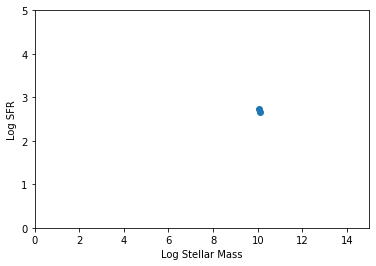

In [26]:
plt.scatter(log_mag_corrected_stellar_mass,log_mag_corrected_SFR)
plt.xlim(0,15)
plt.ylim(0,5)
plt.xlabel('Log Stellar Mass')
plt.ylabel('Log SFR')

In [264]:
#solar_masses = (np.abs(best_H)/(3.826e33))/3.8
#solar_masses